In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [64]:
config={
    'BatchSize':256,
    'seed':42,
    'n_epochs' : 100,
    'lr' : 0.001
}

In [65]:

trainval_dataset = datasets.CIFAR10('data/cifar10', train=True,download=True,transform=transforms.ToTensor())

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor()])

trainval_dataset = datasets.CIFAR10('data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000],generator=torch.Generator().manual_seed(config['seed']))

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

print("Train data number:{}, Valid data number: {}".format(len(train_dataset), len(val_dataset)))

Files already downloaded and verified
Train data number:40000, Valid data number: 10000


In [66]:
class Dropout(nn.Module):
    def __init__(self, dropout_ratio=0.5):
        super().__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x):
        if self.training:
            self.mask = torch.rand(*x.size()) > self.dropout_ratio
            return x * self.mask.to(x.device)
        else:
            return x * (1.0 - self.dropout_ratio)
dropout=Dropout(0.5)

In [67]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=True, path='checkpoint/cifar10_DropOut_checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.__early_stop = False
        self.val_acc_max = -np.Inf
        self.path = path
        
        
    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        return self.__early_stop
        
        
    def update(self, val_acc, model):
        """Call after one epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        if self.best_acc is None:
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
        elif val_acc < self.best_acc:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.__early_stop = True
        else:
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
            self.counter = 0

            
    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc
        
        
        
    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        if self.verbose:
            print(f'Loading model from last checkpoint with validation accuracy {self.val_acc_max:.6f}')
        model.load_state_dict(torch.load(self.path))
        return model

early_stopping=EarlyStopper(patience=7)

In [68]:

class DropOutModel(nn.Module):
    def __init__(self):
        super(DropOutModel, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 3)       # 32x32x3 -> 30x30x32
        self.bn1=nn.BatchNorm2d(32)
        self.av1=nn.ReLU()
        self.pool1=nn.AvgPool2d(2)                  # 30x30x32 -> 15x15x32
        self.conv2=nn.Conv2d(32, 64, 3)             # 15x15x32 -> 13x13x64
        self.bn2=nn.BatchNorm2d(64)
        self.av2=nn.ReLU()
        self.pool2=nn.AvgPool2d(2)                  # 13x13x64 -> 6x6x64
        self.conv3=nn.Conv2d(64, 128, 3)            # 6x6x64 -> 4x4x128
        self.bn3=nn.BatchNorm2d(128)
        self.av3=nn.ReLU()
        self.pool3=nn.AvgPool2d(2)                  # 4x4x128 -> 2x2x128
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(2*2*128, 256)
        self.relu=nn.ReLU()
        self.dropout=dropout
        self.fc2=nn.Linear(256, 10)
        #self.fc1 = nn.Linear(input_size, hidden_size)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.av1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.av2(x)
        x=self.pool2(x)     
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.av3(x)
        x=self.pool3(x)  
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.fc2(x)
        return x

model=DropOutModel()


In [69]:

def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

model.apply(init_weights)

device='cuda'
model.to(device)
optimizer2 = optim.Adam(model.parameters(), lr=config['lr'])
loss_function = nn.CrossEntropyLoss() 

Validation accuracy increased (-inf --> 0.129775).  Saving model ...
EPOCH: 1, Train [Loss: 1.618, Accuracy: 0.408], Valid [Loss: 1.320, Accuracy: 0.519]]
Validation accuracy increased (0.129775 --> 0.154000).  Saving model ...
EPOCH: 2, Train [Loss: 1.240, Accuracy: 0.557], Valid [Loss: 1.091, Accuracy: 0.616]]
EarlyStopping counter: 1 out of 7
EPOCH: 3, Train [Loss: 1.078, Accuracy: 0.619], Valid [Loss: 1.132, Accuracy: 0.600]]
Validation accuracy increased (0.154000 --> 0.158900).  Saving model ...
EPOCH: 4, Train [Loss: 0.977, Accuracy: 0.658], Valid [Loss: 1.033, Accuracy: 0.636]]
Validation accuracy increased (0.158900 --> 0.164800).  Saving model ...
EPOCH: 5, Train [Loss: 0.899, Accuracy: 0.684], Valid [Loss: 0.953, Accuracy: 0.659]]
EarlyStopping counter: 1 out of 7
EPOCH: 6, Train [Loss: 0.831, Accuracy: 0.711], Valid [Loss: 0.993, Accuracy: 0.658]]
Validation accuracy increased (0.164800 --> 0.171450).  Saving model ...
EPOCH: 7, Train [Loss: 0.785, Accuracy: 0.726], Valid [

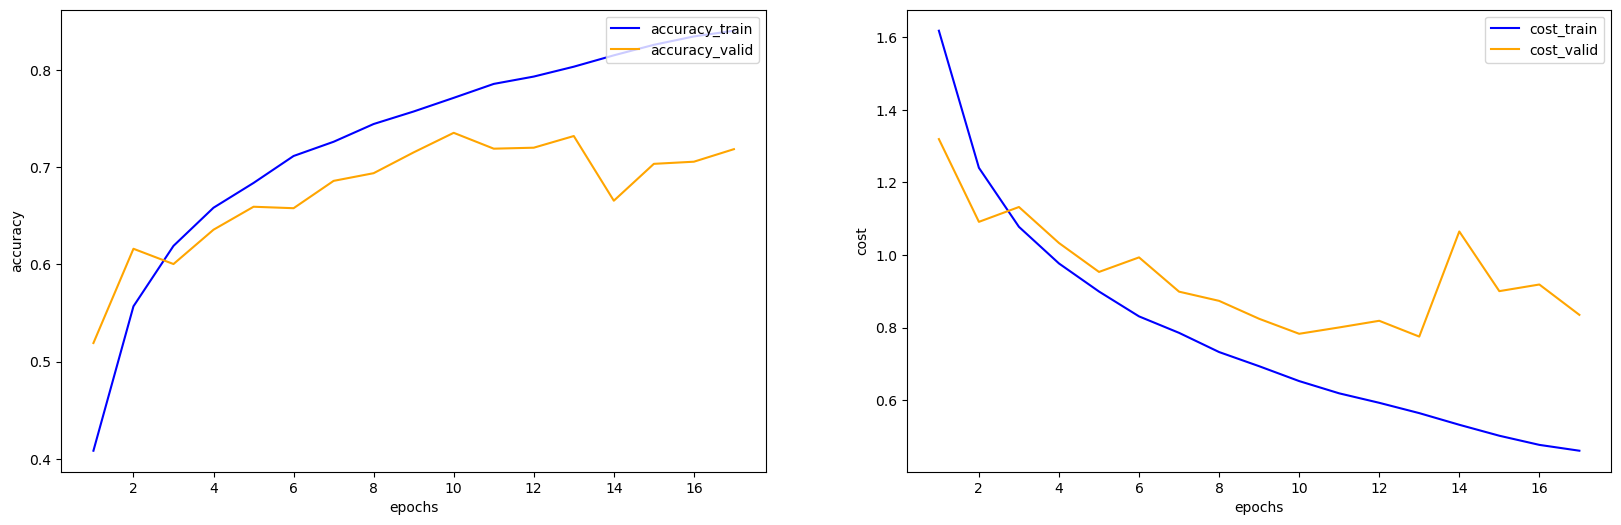

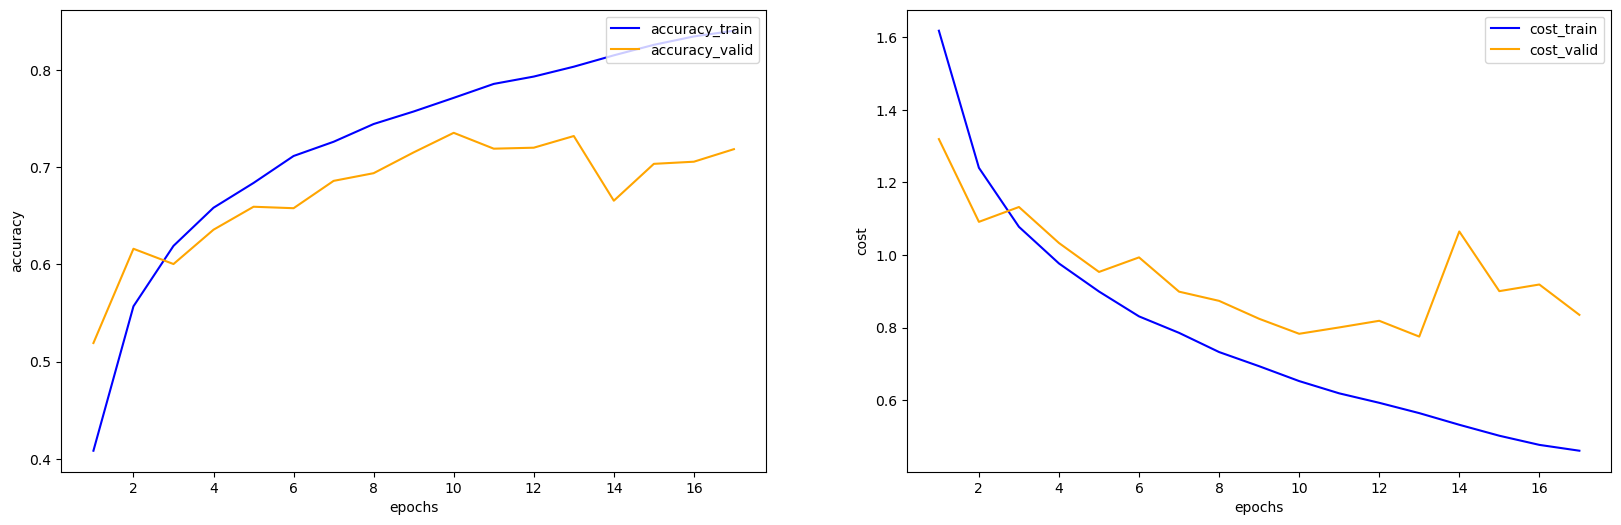

In [70]:
accuracy_train=[]
cost_train=[]
accuracy_valid=[]
cost_valid=[]

for epoch in range(config['n_epochs']):
    losses_train = []
    losses_valid = []

    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        model.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播


        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))

    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    accuracy_valid.append(acc_val/n_val)
    cost_valid.append(np.mean(losses_valid))
    early_stopping.update(acc_val/n_train, model)

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val,
    ))
    if early_stopping.early_stop:
        print('Early stopping !')
        break

model = early_stopping.load_checkpoint(model)

y=len(accuracy_train)

x=np.arange(1,y+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right') 
ax2.legend(loc = 'upper right') 

plt.show()
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')

plt.show()

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 72 %
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1115
           1       0.85      0.83      0.84      1023
           2       0.65      0.63      0.64      1035
           3       0.54      0.56      0.55       954
           4       0.58      0.78      0.66       743
           5       0.73      0.55      0.63      1317
           6       0.83      0.78      0.81      1067
           7       0.63      0.90      0.74       706
           8       0.85      0.82      0.84      1044
           9       0.82      0.82      0.82       996

    accuracy                           0.73     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.74      0.73      0.73     10000



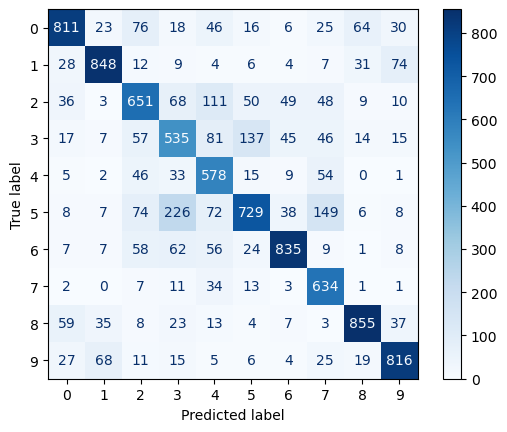

In [71]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pprint

correct = 0
total = 0
prediction=[]
label_list=[]
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        prediction.extend(predicted.tolist())
        label_list.extend(labels.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

metrix=confusion_matrix(prediction,label_list)
print(classification_report(prediction,label_list))
cmp = ConfusionMatrixDisplay(metrix)


cmp.plot(cmap=plt.cm.Blues)